In [ ]:
# %load_ext profila

In [2]:
import zarr
from scipy.spatial.distance import squareform
import numpy as np
import anjl
import pandas as pd
import plotly.express as px
import sys
import time
from contextlib import contextmanager


@contextmanager
def section(*msg):
    print(*msg, file=sys.stdout, end="... ")
    sys.stdout.flush()
    before = time.time()
    try:
        yield
    finally:
        after = time.time()
        duration = after - before
        print(f"done in {duration:.2f}s", file=sys.stdout)
        sys.stdout.flush()


def run_diagnostics(D):
    with section("canonical"):
        _, timings_canonical, searched_canonical, visited_canonical = anjl.canonical_nj(
            D,
            diagnostics=True,
        )

    with section("rapid_gc100"):
        _, timings_rapid_gc100, searched_rapid_gc100, visited_rapid_gc100 = (
            anjl.rapid_nj(
                D,
                diagnostics=True,
                gc=100,
            )
        )

    with section("rapid_gc10"):
        _, timings_rapid_gc10, searched_rapid_gc10, visited_rapid_gc10 = anjl.rapid_nj(
            D,
            diagnostics=True,
            gc=10,
        )

    with section("rapid_nogc"):
        _, timings_rapid_nogc, searched_rapid_nogc, visited_rapid_nogc = anjl.rapid_nj(
            D,
            diagnostics=True,
            gc=None,
        )

    df_canonical = pd.DataFrame(
        {
            "time": timings_canonical,
            "searched": searched_canonical,
            "visited": visited_canonical,
            "iteration": np.arange(len(timings_canonical)),
            "algorithm": "canonical",
        }
    )
    df_rapid_gc100 = pd.DataFrame(
        {
            "time": timings_rapid_gc100,
            "searched": searched_rapid_gc100,
            "visited": visited_rapid_gc100,
            "iteration": np.arange(len(timings_rapid_gc100)),
            "algorithm": "rapid_gc100",
        }
    )
    df_rapid_gc10 = pd.DataFrame(
        {
            "time": timings_rapid_gc10,
            "searched": searched_rapid_gc10,
            "visited": visited_rapid_gc10,
            "iteration": np.arange(len(timings_rapid_gc10)),
            "algorithm": "rapid_gc10",
        }
    )
    df_rapid_nogc = pd.DataFrame(
        {
            "time": timings_rapid_nogc,
            "searched": searched_rapid_nogc,
            "visited": visited_rapid_nogc,
            "iteration": np.arange(len(timings_rapid_nogc)),
            "algorithm": "rapid_nogc",
        }
    )

    df_diagnostics = pd.concat(
        [
            df_rapid_gc100,
            df_rapid_gc10,
            df_rapid_nogc,
            df_canonical,
        ],
        axis=0,
    )

    px.line(
        df_diagnostics,
        x="iteration",
        y="time",
        color="algorithm",
        template="simple_white",
    ).show()

    px.line(
        df_diagnostics,
        x="iteration",
        y="searched",
        color="algorithm",
        template="simple_white",
    ).show()

    px.line(
        df_diagnostics,
        x="iteration",
        y="visited",
        color="algorithm",
        template="simple_white",
    ).show()

## Small

In [3]:
small = zarr.load("../data/small/dist.zarr.zip")
small_D = squareform(small)
small_D.shape

(181, 181)

In [4]:
small_Z = anjl.canonical_nj(small_D)

In [5]:
small_Z_r = anjl.rapid_nj(small_D, gc=None)

In [6]:
small_Z_r = anjl.rapid_nj(small_D, gc=1)

In [7]:
%%timeit -r100 -n1
anjl.canonical_nj(small_D)

1.88 ms ± 318 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [8]:
%%timeit -r100 -n1
anjl.rapid_nj(small_D, gc=None)

5.18 ms ± 511 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [9]:
%%timeit -r100 -n1
anjl.rapid_nj(small_D, gc=100)

5.42 ms ± 620 μs per loop (mean ± std. dev. of 100 runs, 1 loop each)


canonical... done in 0.00s
rapid_gc100... done in 0.01s
rapid_gc10... done in 0.01s
rapid_nogc... done in 0.01s


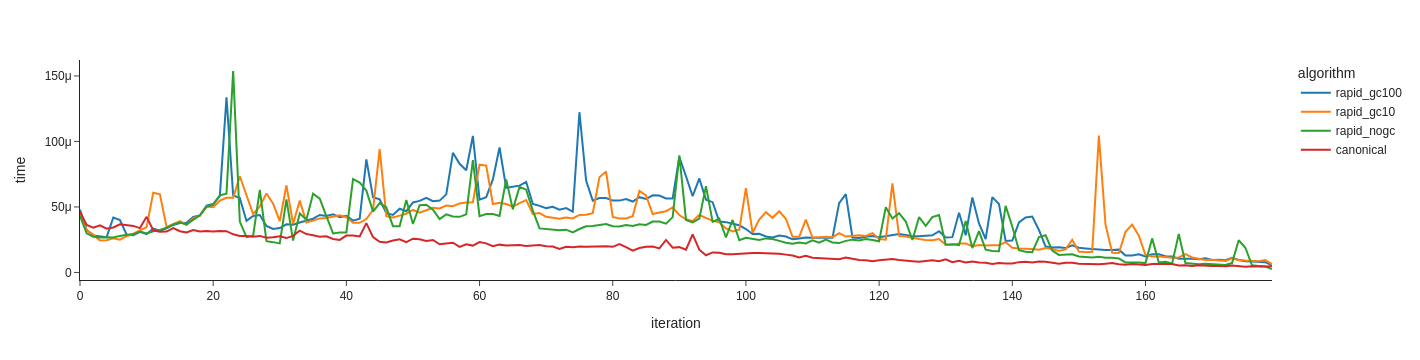

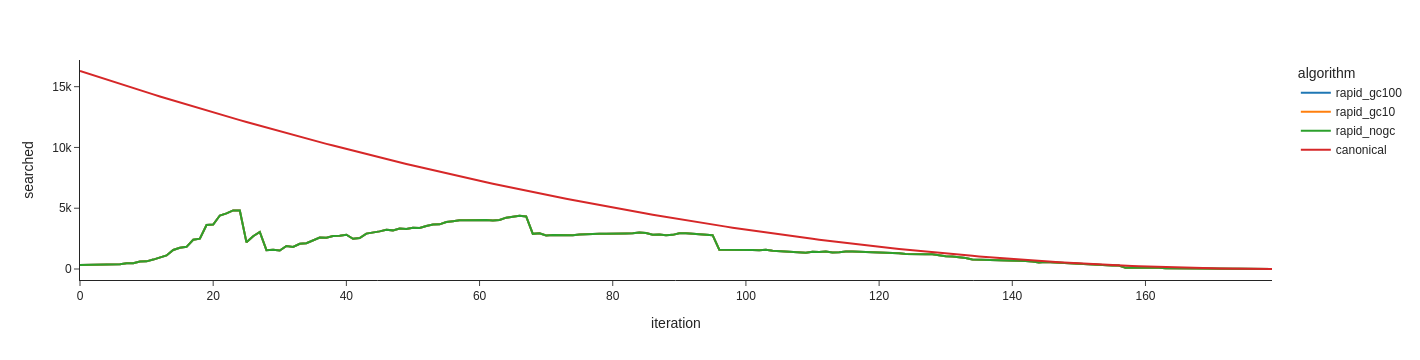

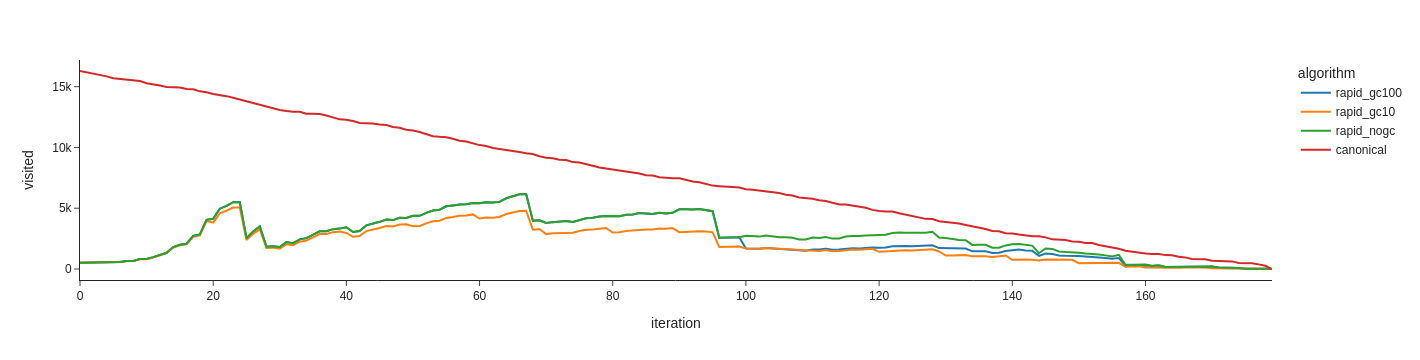

In [10]:
run_diagnostics(small_D)

## Medium

In [11]:
medium = zarr.load("../data/medium/dist.zarr.zip")
medium_D = squareform(medium)
medium_D.shape

(472, 472)

In [12]:
medium_Z = anjl.canonical_nj(medium_D)

In [13]:
medium_Z_r = anjl.rapid_nj(medium_D)

In [14]:
%%timeit -r50 -n1
anjl.canonical_nj(medium_D)

26.8 ms ± 2.45 ms per loop (mean ± std. dev. of 50 runs, 1 loop each)


In [15]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=None)

54.9 ms ± 2.7 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [16]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=10)

42.5 ms ± 2.06 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [17]:
%%timeit -r30 -n1
anjl.rapid_nj(medium_D, gc=100)

48.1 ms ± 5.63 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


In [18]:
%%timeit -r20 -n1
anjl.rapid_nj(medium_D, gc=1)

85.5 ms ± 5.31 ms per loop (mean ± std. dev. of 20 runs, 1 loop each)


canonical... done in 0.03s
rapid_gc100... done in 0.05s
rapid_gc10... done in 0.05s
rapid_nogc... done in 0.06s


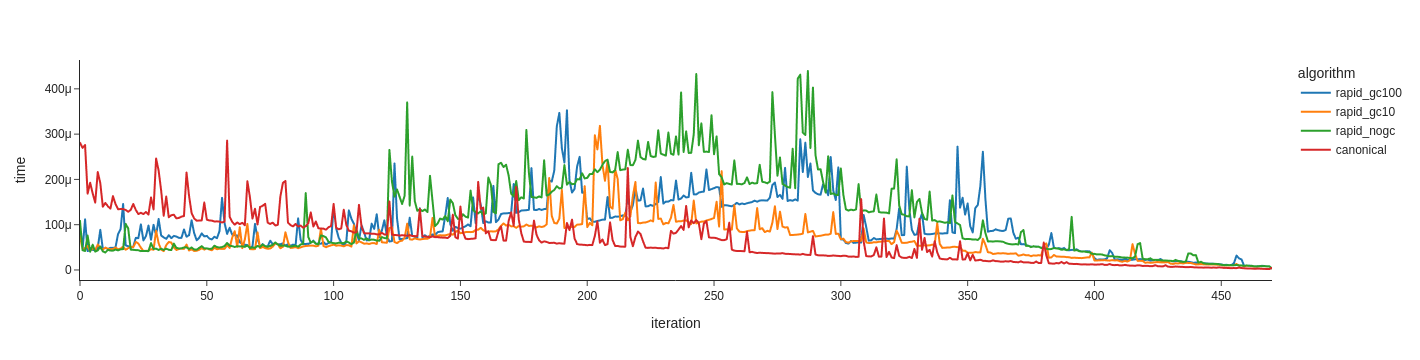

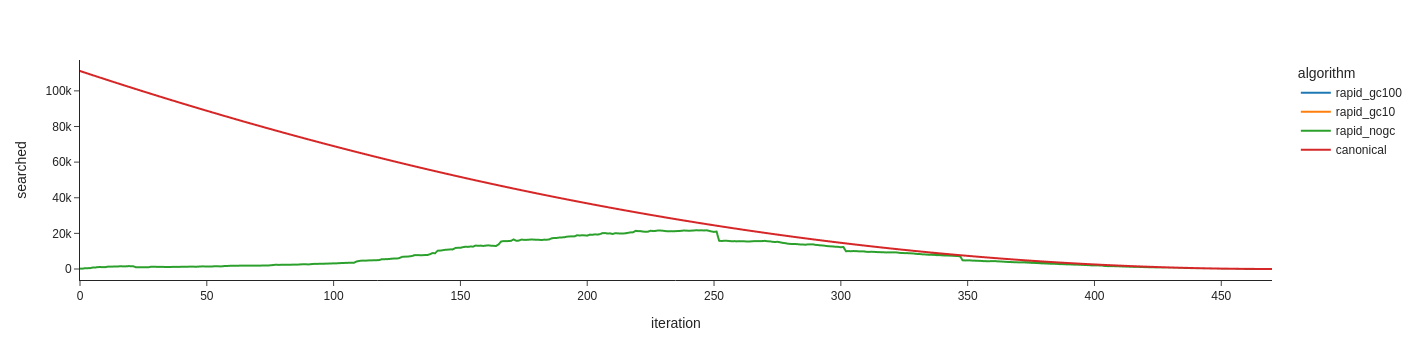

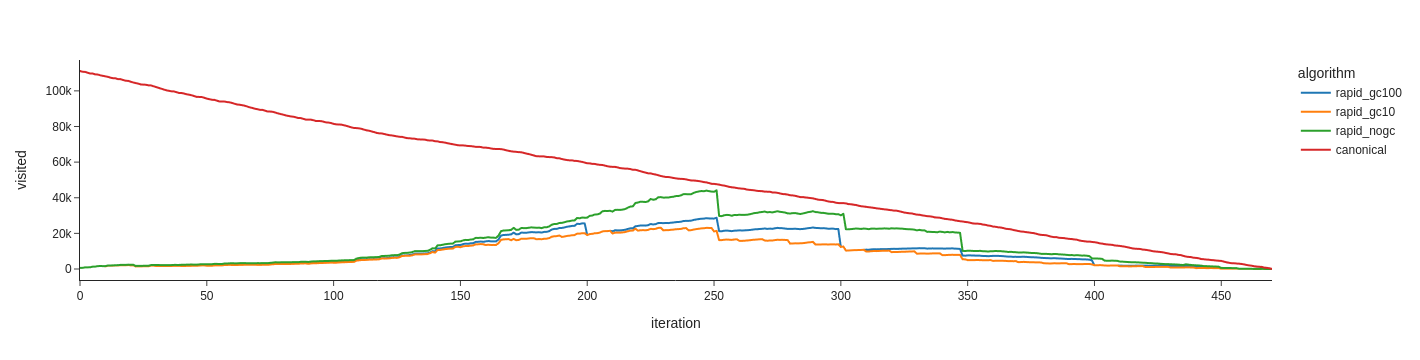

In [19]:
run_diagnostics(medium_D)

In [17]:
# %%profila
# anjl.canonical_nj(medium_D)

In [18]:
# %%profila
# anjl.rapid_nj(medium_D, gc=100)

## Large

In [20]:
large = zarr.load("../data/large/dist.zarr.zip")
large_D = squareform(large)
shuffle = np.random.choice(large_D.shape[0], size=2000, replace=False)
large_D_shuffled = large_D.take(shuffle, axis=0).take(shuffle, axis=1)
large_D_shuffled

array([[ 0., 19., 23., ..., 25., 14., 20.],
       [19.,  0., 14., ..., 30., 15., 11.],
       [23., 14.,  0., ..., 32., 21., 13.],
       ...,
       [25., 30., 32., ...,  0., 21., 33.],
       [14., 15., 21., ..., 21.,  0., 18.],
       [20., 11., 13., ..., 33., 18.,  0.]], dtype=float32)

canonical... done in 1.84s
rapid_gc100... done in 1.80s
rapid_gc10... done in 2.20s
rapid_nogc... done in 3.24s


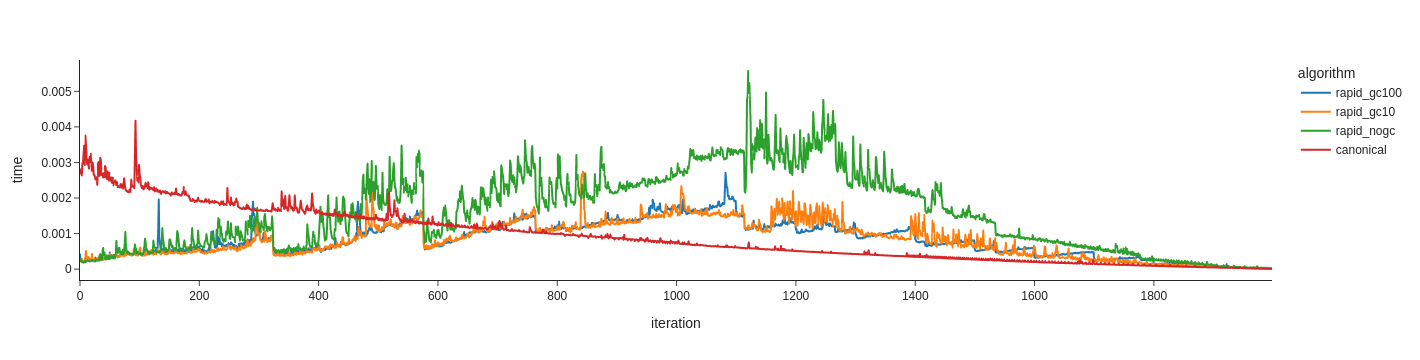

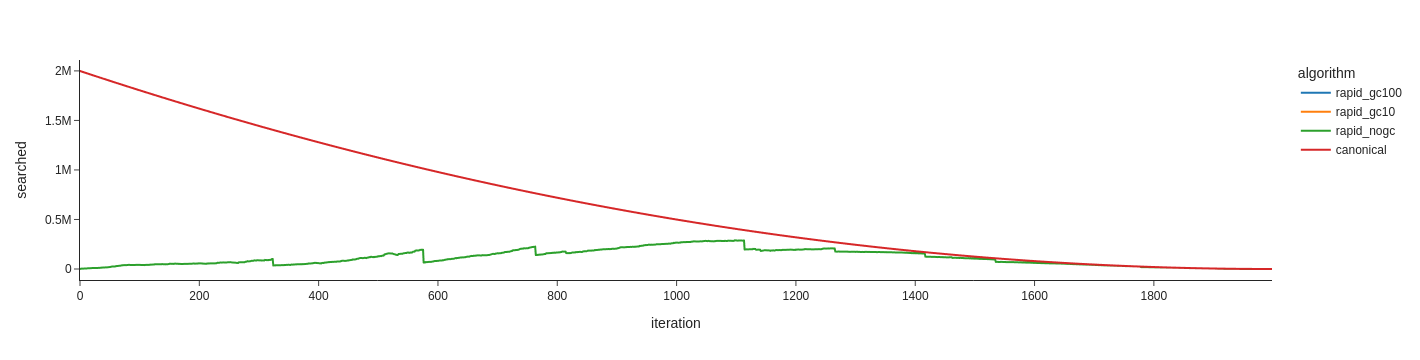

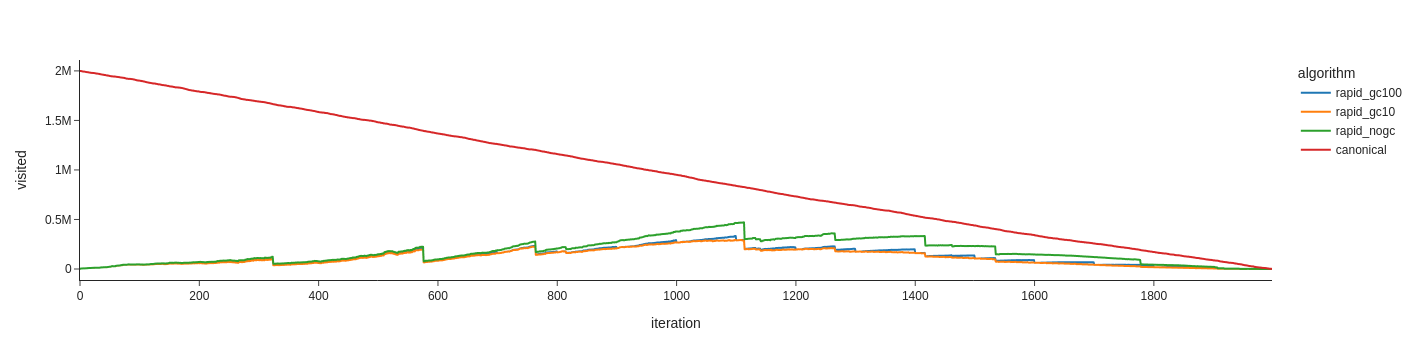

In [21]:
run_diagnostics(large_D_shuffled)

In [ ]:
# %%profila
# large_Z = anjl.canonical_nj(large_D_shuffled)

# %%profila
# large_Z = anjl.rapid_nj(large_D_shuffled, gc=100)

In [ ]:
%%timeit -r5 -n1
anjl.canonical_nj(large_D_shuffled)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=10)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=100)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=200)

In [ ]:
%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=None)

In [ ]:
%%timeit -r3 -n1
np.argsort(large_D_shuffled, axis=1)

In [ ]:
%%timeit -r1000 -n1
np.argsort(large_D_shuffled[0])

## XL

In [40]:
xxl = zarr.load("../data/xxl/dist.zarr.zip")
xxl_D = squareform(xxl)
xxl_D.shape

(5868, 5868)

In [41]:
xxl_shuffle = np.random.choice(xxl_D.shape[0], size=4000, replace=False)
xxl_D_shuffled = xxl_D.take(xxl_shuffle, axis=0).take(xxl_shuffle, axis=1)
xxl_D_shuffled

array([[ 0., 29., 26., ..., 22., 30., 29.],
       [29.,  0., 19., ..., 17., 19., 20.],
       [26., 19.,  0., ..., 22., 16., 17.],
       ...,
       [22., 17., 22., ...,  0., 26., 23.],
       [30., 19., 16., ..., 26.,  0., 21.],
       [29., 20., 17., ..., 23., 21.,  0.]], dtype=float32)

In [ ]:
# %%profila
# large_Z = anjl.canonical_nj(large_D_shuffled)

# %%profila
# large_Z = anjl.rapid_nj(large_D_shuffled, gc=100)

canonical... done in 1.87s
rapid_gc100... done in 2.39s
rapid_gc10... done in 2.55s
rapid_nogc... done in 3.17s


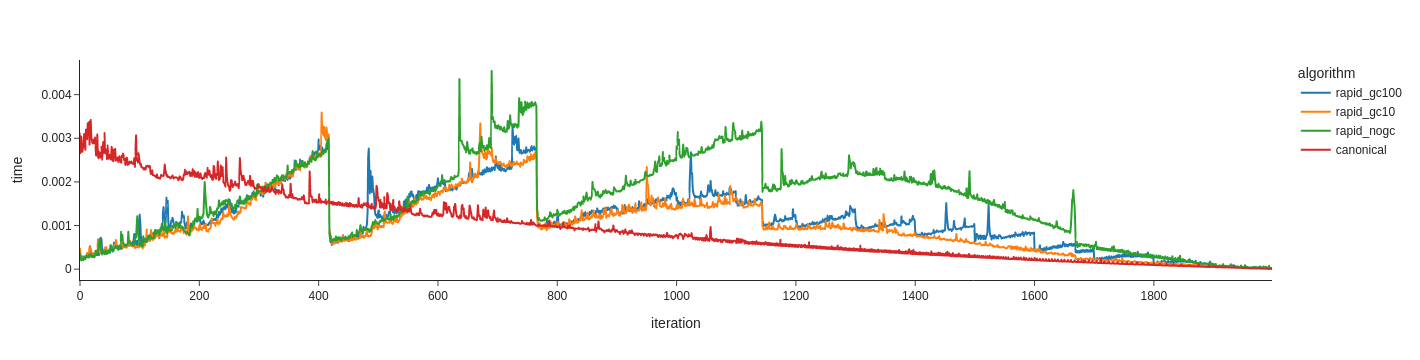

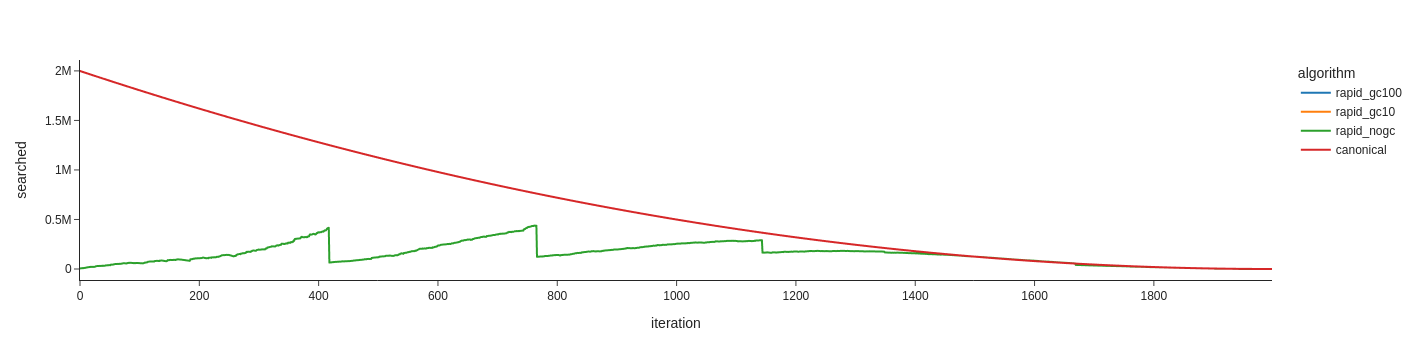

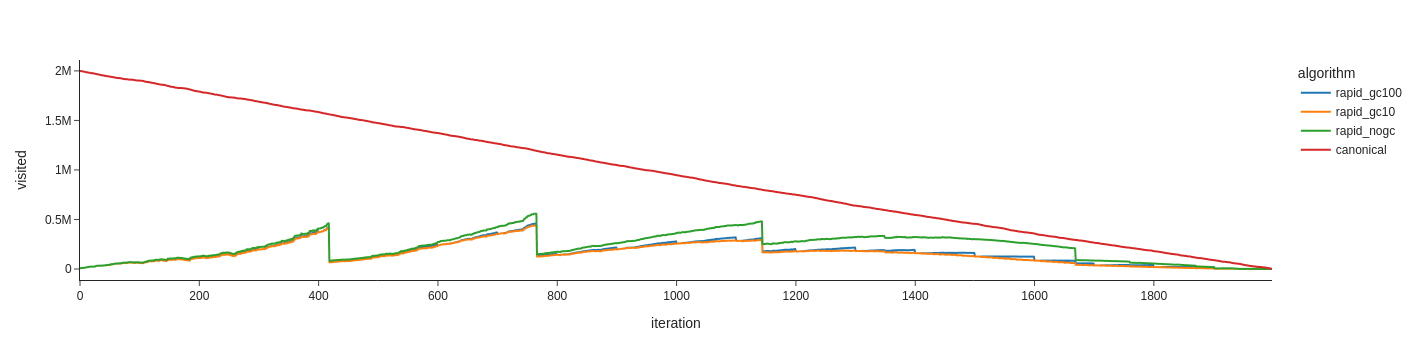

In [72]:
run_diagnostics(large_D_shuffled)

In [ ]:
%%timeit -r5 -n1
anjl.canonical_nj(large_D_shuffled)

%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=10)

%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=100)

%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=200)

%%timeit -r5 -n1
anjl.rapid_nj(large_D_shuffled, gc=None)

%%timeit -r3 -n1
np.argsort(large_D_shuffled, axis=1)

In [ ]:
import anjl._canonical
import anjl._rapid

In [ ]:
# anjl._canonical._canonical_nj_search.inspect_types()

In [ ]:
# anjl._rapid._rapid_search.inspect_types()